## Loading libraries

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
??DecisionTreeClassifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/groverprince/Documents/msan/msan_ml/fastai')

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from ggplot import *

## Loading feather data already half processed

In [4]:
PATH = "/Users/groverprince/Documents/msan/msan_ml/fastai/courses/ml1"

df_raw = pd.read_feather('/Users/groverprince/Documents/msan/msan_ml/fastai/courses/ml1/tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

## Random forest from scratch (copied from Jeremy's)

In [6]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
                
    def tree_std(self,x_val): pass
    def pred_ci(self, x_val) : pass
    def plot_ci(self, x_val, y_val, n_pnt=100): pass
    
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [7]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        #self.path = []
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi) 
    
    def contributions(self, xi): pass
        
       

## Random forest interpretetion from scratch (self)

### Confidence based on tree variance. 

The idea is to take out predictions of all the validation observations and find for which of those validation data points, we are least confident. Then we can look at some pattern in those 

(Standard deviation means std deviation of Yi predictions from n_estimators. Output will have n_rows as number of rows in validation set)

**What are we going to get out of this -- **  

* For *categorical variables*, for which category we are least confident about predictions . 
* For *continuous variables*, in what range are we least confident about predictions . 

In [336]:
def tree_std(self,x_val):
    std =  np.std([t.predict(x_val) for t in self.trees], axis=0)
    self.std = std
    return std

TreeEnsemble.tree_std = tree_std

def pred_ci(self, x_val, percentile = 95):   
    
    """
    x_val = validation input
    percentile = required confidence level
    """

    allTree_preds = np.stack([t.predict(x_val) for t in self.trees], axis = 0)
    
    err_down = np.percentile(allTree_preds, (100 - percentile) / 2.0  ,axis=0)
    err_up = np.percentile(allTree_preds, 100- (100 - percentile) / 2.0  ,axis=0)
    
    self.err_down = err_down
    self.err_up = err_up
    
    return err_down, err_up
    
TreeEnsemble.pred_ci = pred_ci
                
    
def plot_ci(self, x_val, y_val, n_pnt=100, doPlot=True):
    """
    x_val = validation input (independent)
    y_val = validation output (dependent)
    n_pnt = number of indexes to be shown in plot (sorted based on least confident predictions)

    """
    ci = self.pred_ci(x_val)[1] - self.pred_ci(x_val)[0]
    #plt_indx = np.argsort(-ci)[n_pnt]
    plt_idx = np.argsort(ci)[::-1][:n_pnt]
    yhat = self.predict(x_val)
    y = y_val
    
    df = pd.DataFrame()
    df['down'] = self.pred_ci(x_val)[0] 
    df['up'] = self.pred_ci(x_val)[1]
    df['y'] = y
    df['yhat'] = yhat
    df['error'] = df['up'] - df['down']
    
    df_out = df.iloc[plt_idx]
    df_out.reset_index(inplace=True)
    
    
    if doPlot is True :
        plt.figure(figsize= (15,7))

        plt.errorbar(df_out['index'], df_out['yhat'], yerr= df_out['error'], fmt='o',
                     ecolor='g',  elinewidth = 0.4)
        plt.plot(df_out['index'], df_out['y'], 'r^')
        plt.xlabel('Index')
        plt.ylabel('Predictions')
        plt.title(f'Prediction intervals for worse {n_pnt} predictions')
        plt.locator_params(nbins=4)
        plt.legend()
        plt.show()
    
    return plt_idx, df
    
TreeEnsemble.plot_ci = plot_ci
        

In [11]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [490]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

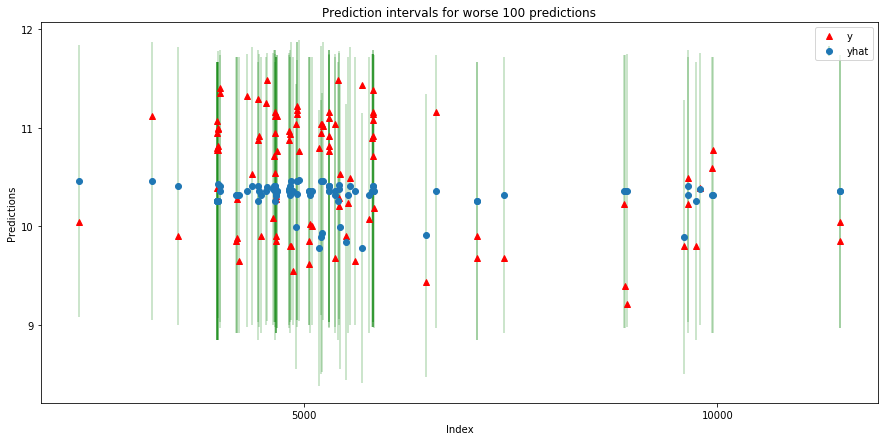

In [359]:
# features with maximum confidence interval and worse n predictions 
pred_int = X_valid[cols].iloc[ens.plot_ci(X_valid[cols].values, y_valid, 100)[0]]

In [360]:
pred_int

,MachineID,YearMade,MachineHoursCurrentMeter,ProductSize,Enclosure,Coupler_System,saleYear
394558,1319057,1986,0.0,0,3,0,2011
394028,1275846,1986,0.0,0,3,0,2011
395593,384547,1000,0.0,5,1,0,2011
394062,574764,1983,0.0,4,1,0,2011
394333,1290844,1991,0.0,0,3,0,2011
393078,1791687,1984,0.0,2,3,0,2011
393769,1838187,1984,0.0,2,3,0,2011
393070,1807106,1984,0.0,2,6,0,2011
394536,1828168,1985,0.0,2,1,0,2011
393069,1809809,1984,0.0,2,1,0,2011


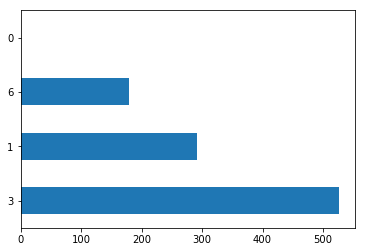

In [357]:
pred_int.Enclosure.value_counts().plot.barh()

For e.g. above plot shows that for most of **Enclosure corresponding to code 1**, we are not confident with  predictions.

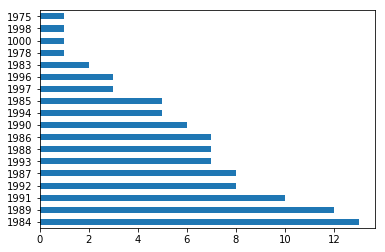

In [313]:
pred_int.YearMade.value_counts().plot.barh()

Above plot shows that we are least confident about predictions for **Year = 1984**

In [352]:
x = raw_valid.copy()
x['pred_std'] = ens.plot_ci(X_valid[cols].values, y_valid, doPlot=False)[1].error.reshape(x.shape[0],1)
#ens.tree_std(X_valid[cols].values)
x['pred'] = ens.predict(X_valid[cols].values)

In [354]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,10.117707,0.644770
Large,10.470589,10.302451,0.864983
Large / Medium,10.691871,10.718395,0.575581
Medium,10.681511,10.604615,0.612460
Mini,9.535147,9.562749,0.424186
Small,10.324448,10.368326,0.459777


In [355]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.083959
Compact           0.063727
Medium            0.057754
Large / Medium    0.053700
Mini              0.044358
Small             0.044344
dtype: float64

Above shows we are least confident about **large and compact** product sizes

### Feature importance

Using the same random forest model, by predicting on randomized values on specific column, we can find out if that specific column has high importance for prediction or not.

In [404]:
# defining rmse as scoring criteria (therefore smaller is better)

def score(x1,x2):
    return metrics.mean_squared_error(x1,x2)

In [408]:
def feat_imp(m,x,y, small_bet = True):
    score_list = {}
    score_list['original'] = score(m.predict(x.values), y)
    imp = {}
    for i in range(len(x.columns)):
        rand_idx = np.random.permutation(len(x))
        new_coli = x.values[rand_idx, i]
        
        new_x = x.copy()
        new_x[x.columns[i]] = new_coli
        
        score_list[x.columns[i]] = score(m.predict(new_x.values), y)
        
        imp[x.columns[i]] = score_list['original'] - score_list[x.columns[i]]   
        
    if small_bet:
        return sorted(imp.items(), key=lambda x: x[1])
    else:
        return sorted(imp.items(), key=lambda x: x[1], reverse=True)
                           

In [455]:
importance = feat_imp(ens, X_train[cols], y_train)

In [456]:
importance

[('YearMade', -0.21947050888595573),
 ('Coupler_System', -0.21318328275792894),
 ('ProductSize', -0.18353291714217482),
 ('saleYear', -0.045706193607739254),
 ('Enclosure', -0.041566508577359523),
 ('MachineID', -0.01399141076436905),
 ('MachineHoursCurrentMeter', -1.9246700722952426e-05)]

Now if some feature decreases RMSE (score) after being shuffled means that the model is better off without that feature. Meaning - that removing that feature is going to make model better. 

The featuure which make predictions very bad after being removed is one which must be very important for the model. That's how the feature importance is decided.  

By looking at the above results, we can remove **MachineHoursCurrentMeter** and look at the plot of other feature importances. Let's just plot all of them for now

In [457]:
di = {'feat': [i[0] for i in importance], 'imp': [-i[1] for i in importance]}
df_imp = pd.DataFrame(di)

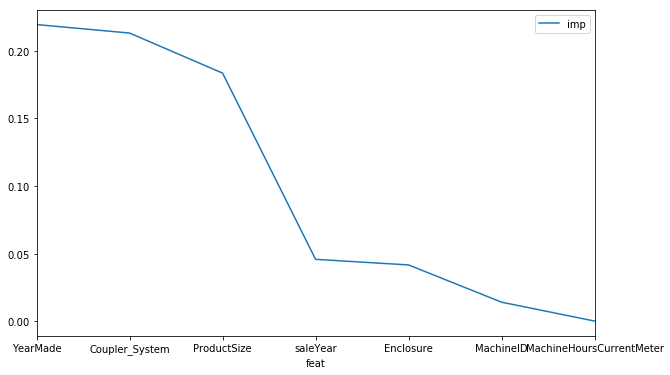

In [458]:
df_imp.plot('feat', 'imp', figsize=(10,6))

From the above plot, **Coupler system, ProductSize, YearMade** are 3 most importance features among all other selected features.  

Let's see what **sklearn random forest** say about importance features

In [450]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)

In [451]:
m = rf.fit(X_train[cols], y_train)

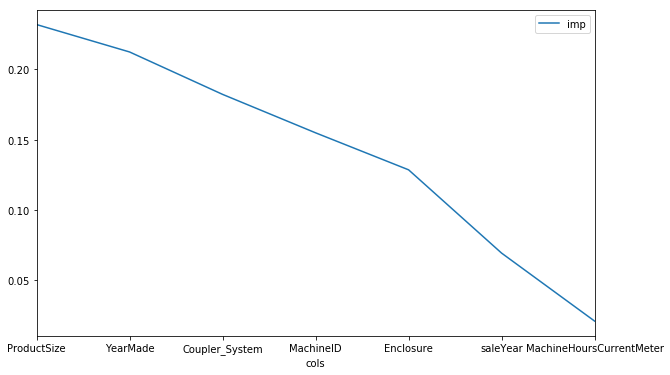

In [452]:
rf_feat_importance(m, X_train[cols]).plot('cols', 'imp', figsize = (10,6))

As observed from the 2 plots, feature importance is more or less same as **sklearn** implementation. 

### Tree Interpretor

**Feature importance** (as in above section) is useful if we want to analyze which features are important for overall random forest model. But if we are interested in one particular observation, then the role of **tree interpretor** comes into play.   

*For example, there is a RF model which predicts - **a patient X coming to hospital has high probability of readmission or not?**. For sake of similicity, let's consider we only have 3 features - `patient's blood pressure data, patient's age and patient's sex`. Now, if our model says that `person A` has 80% chances of readmission, how can we know ** what is special in that person A that our model predicts he/she will be readmitted ? **.  In this case, tree interpretor tells the **prediction path ** followed for that particular patient. Something like, because **patient A** is 65 years old male, that is why our model predicts that he will be readmitted. Another **patient B** who my model predicts to be readmitted might be because B has high blood pressure (not because of age or sex).   *

To conclude, each observation follows a different path of the tree and has different feature contributions for it's prediction

In [20]:
def contributions(self, xi, path = None):
    
    
    if self.is_leaf: return path.append(self.val)
    
    if path == None: path = []
        
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs  
    try:
        path.append((t.val, t.split_name, t.split))
    except AttributeError:
        pass
    
    t.contributions(xi, path)
    return path

DecisionTree.contributions = contributions

In [28]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)
tree = ens.trees[3]
tree.predict_row(X_valid.values[10])

9.4413227521592749

In [29]:
contr = []
contr = tree.contributions(X_valid.values[10])

In [30]:
contr

[(9.2304130502447865, 'YearMade', 1998.0),
 (9.3440723845211835, 'YearMade', 2001.0),
 (9.4090407478427167, 'saleYear', 2007.0),
 (9.3698557938690321, 'YearMade', 2005.0),
 9.4413227521592749]

In [737]:
prediction = tree.predict_row(X_valid.values[1])
bias = np.mean(y_valid)
bias